In this notebook I train one autoencoder for bare soil reconstruction from Landsat 8: monthly composite during one year and bands:  'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'. Input training data has been obtained from LUCAS reference baresoil points dataset and GEE images. Data is cleaned in clean_FeatureCollection.ipynb

In [1]:
base_path = '/home/clara/'  # '/home/clara'  # '/cats/datastore3/claraenv/code/my-projects/'  # '/home/clara/Documents/'

# Input data

In [2]:
test_size = 0.3
n_hidden_neurons = 5
optimizer = 'Adam'
batch_size = None

In [3]:
#text = None
text = ''' !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
REPEAT: I changed all data structure. Now there are 7 reflectances and one date as features.
'''

# Libraries

In [4]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip
from random import randint
import math
import re
import random

'''Data Viz'''
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
import matplotlib.cm as cm
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import joblib 

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

from osgeo import gdal
from osgeo import gdal_array
import matplotlib.pyplot as plt
import numpy as np
import sys
from osgeo.gdalconst import *
import os

import math
import codecs

import osgeo #this is necessary for the type comparison in some methods
from osgeo import osr
from osgeo import ogr
from collections import defaultdict
import itertools
from osgeo import gdal_array as gdar
from osgeo import gdalconst as gdct
import glob

# Paths

In [5]:
## Create a folders
mf = f'{base_path}/autoencoders/bare_soil-detection/models/'
mf2 = f'{base_path}/autoencoders/bare_soil-detection/figures/'
path_txt = f'{base_path}/autoencoders/bare_soil-detection/results/results.txt'

# Training and testing

In [6]:
# import data
data = pd.read_csv(f'{base_path}/autoencoders/bare_soil-detection/results/clean_data/bareland_LUCAS_2015.csv')
del data['Unnamed: 0']

# Get column names
bands = data.columns
print('Bands:', bands)

# convert data to array
data_array = np.array(data)
print('data shape:', data_array.shape)

# clean nan
data_clean = data_array[~np.isnan(data_array).any(axis=1)]
print('data clean:', data_clean.shape)

# split training and testing
train, test = train_test_split(data_clean, test_size = test_size, random_state = 1961)
print('training shape', train.shape)
print('testing shape', test.shape)

Bands: Index(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'date'], dtype='object')
data shape: (2416, 8)
data clean: (2175, 8)
training shape (1522, 8)
testing shape (653, 8)


# Scaling

In [7]:
scaler = pp.MinMaxScaler()

# training
train_scaled = np.array(scaler.fit_transform(train))
joblib.dump(scaler, f'{base_path}/autoencoders/bare_soil-detection/models/scale.mod')

# testing
scaler = joblib.load(f'{base_path}/autoencoders/bare_soil-detection/models/scale.mod')
test_scaled = np.array(scaler.transform(test))

---------------------------------------------------------------------------------------------------------

# Autoencoder

Training the model...
Epoch 00021: early stopping
Min error: 0.0001233142684213817
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /home/clara//autoencoders/bare_soil-detection/models/assets


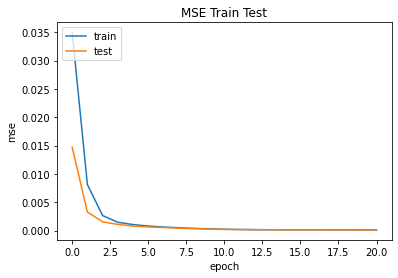

Epoch 00018: early stopping
Min error: 0.00015150320541579276
Epoch 00027: early stopping
Min error: 0.00010661784472176805
INFO:tensorflow:Assets written to: /home/clara//autoencoders/bare_soil-detection/models/assets


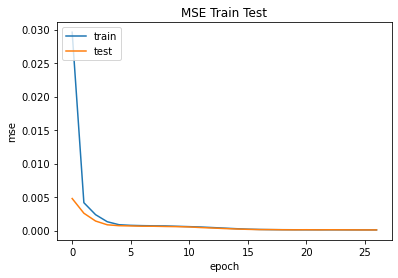

Epoch 00018: early stopping
Min error: 0.0001075178588507697
Epoch 00025: early stopping
Min error: 0.00018745483248494565
Epoch 00017: early stopping
Min error: 0.0002806622942443937
Running time AE --- minutes ----0.1468166470527649


In [8]:
# early stopping
es = keras.callbacks.EarlyStopping(monitor = 'mse', mode = 'min', min_delta = 0.001, verbose = 2, patience = 12) 

start = time.time()

lowest_error = 100000000

## Train AE
print('Training the model...')
for n in range(6):
    # Create model
    model = Sequential()

    # Create layers
    model.add(Dense(units=n_hidden_neurons, activation='linear', input_dim=train_scaled.shape[1]))
    model.add(Dense(units=train_scaled.shape[1], activation='linear'))

    # Compile model (a traditional default value for the learning rate is 0.1 or 0.01)
    if optimizer == 'Adam':
        opt = keras.optimizers.Adam(learning_rate=0.01)
    tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
    model.compile(optimizer=opt, loss="mean_squared_error", metrics=['mse'])

    # Train
    history = model.fit(x=train_scaled, y=train_scaled,
                        epochs=200,
                        batch_size= batch_size,
                        shuffle=True,
                        validation_data=(test_scaled,test_scaled),
                        verbose=0,
                        callbacks=[es])

    # Save best model
    error = min(history.history['mse'])
    print(f'Min error: {error}')

    if error < lowest_error:
        lowest_error = error
        model.save(mf, overwrite=True, include_optimizer=True)
        # Plot train-test curves
        plt.plot(history.history['mse'])
        plt.plot(history.history['val_mse'])
        plt.title(f'MSE Train Test')
        plt.ylabel('mse')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig(f'{mf2}/traintestCurvesAE.png', format='png', dpi=300)
        plt.show()
    pass

end = time.time()

print(f'Running time AE --- minutes ----{(end-start)/60}')

In [9]:
train_error = np.sum(np.array(history.history['mse']))
test_error = np.sum(np.array(history.history['val_mse']))
print('train error:', train_error)
print('test error:', test_error)

train error: 0.0480477181263268
test error: 0.020675475359894335


# Reconstruction

In [10]:
# Models
model = keras.models.load_model(mf)
scaler = joblib.load(f'{base_path}/autoencoders/bare_soil-detection/models/scale.mod')

# Scale data
data_scaled = scaler.transform(data_clean)

# Predict
reconstruction_scaled = model.predict(x=data_scaled, verbose=1)

# Descale
reconstruction = scaler.inverse_transform(reconstruction_scaled)

68/68 [==============================] - 0s 387us/step


# Scatter plot reconstruction per band

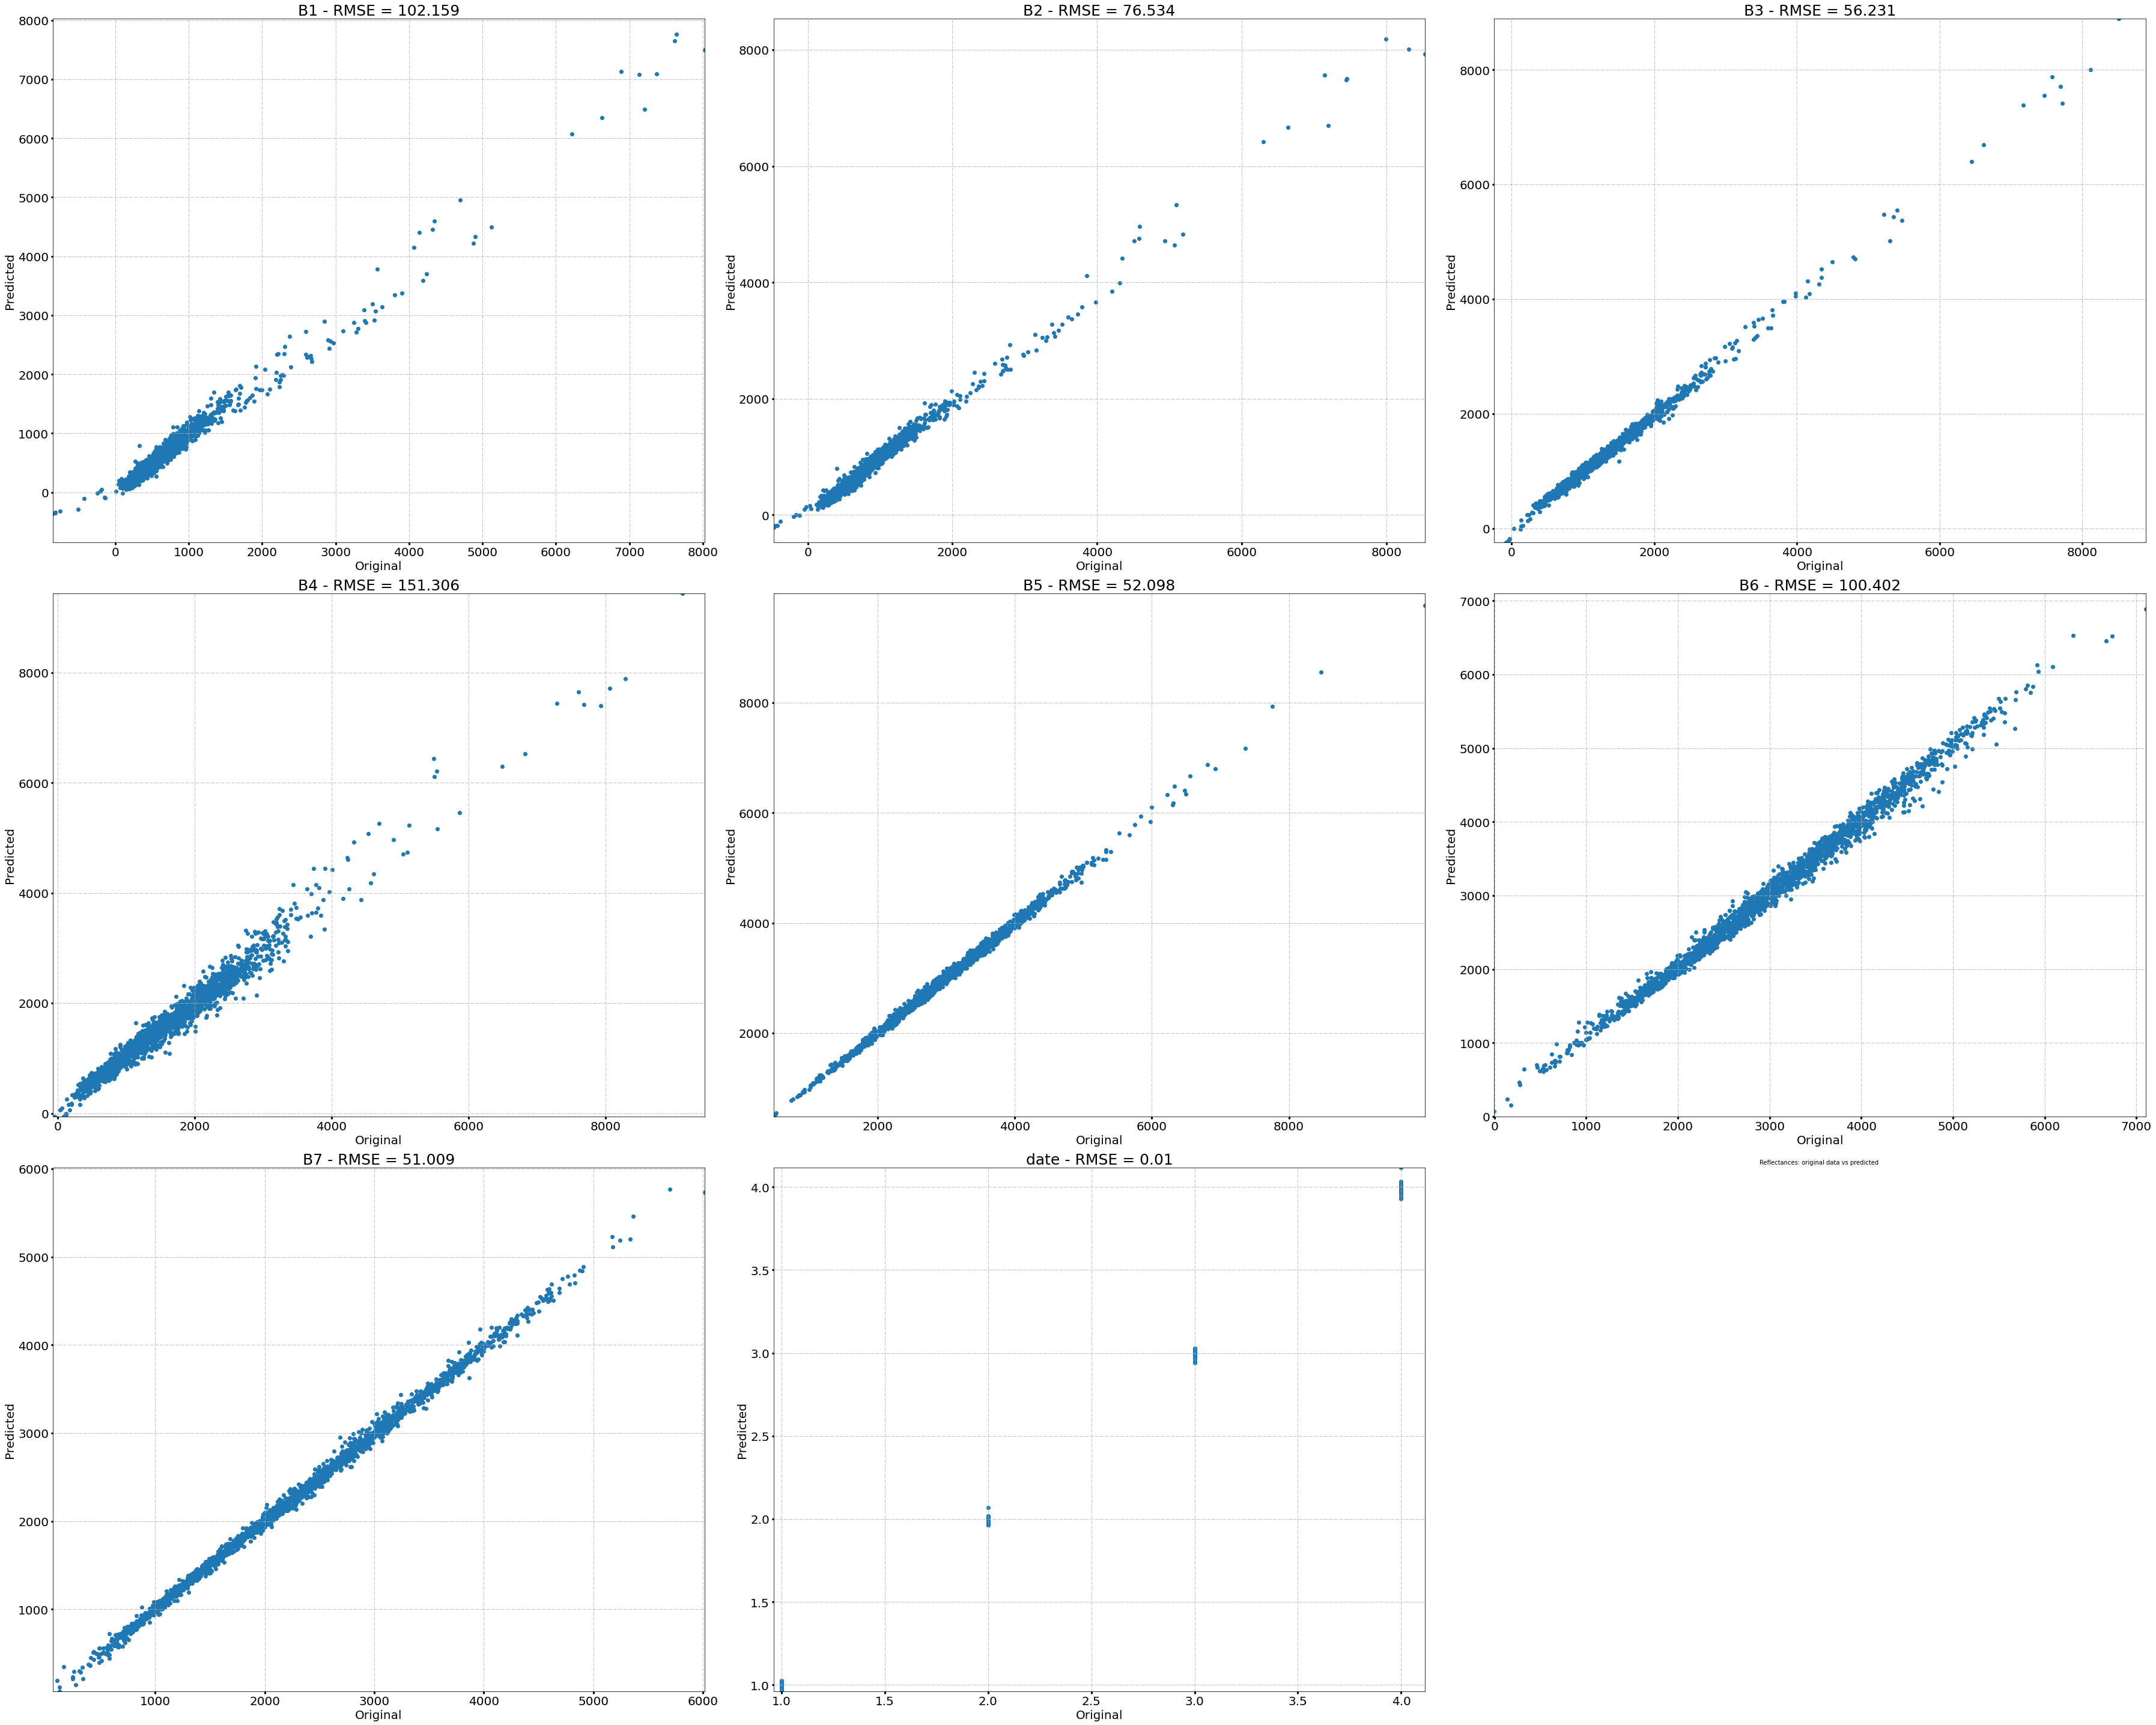

Total RMSE: 589.749


In [11]:
# Prepare subplots
n_figures = len(bands)
n_rows = int(math.ceil((n_figures)**(1/2))) #add an extra row to have space for the colorbar
n_cols = int(math.ceil(n_figures/n_rows))
rows=[]
columns = []
for row in range(n_rows):
    for col in range(n_cols):
        rows.append(row)
        columns.append(col)

# Plot reflectances original pixel vs. reconstructed
fig, axs = plt.subplots(n_rows, n_cols, figsize= (50,40))
rms_all = []

# reflectance bands: B1, B2, B3, B4, B5
for sp in range(n_figures):
    ori_sublist = []
    pre_sublist = []
    ori = list(data_clean[:,sp])
    pre = list(reconstruction[:,sp])
    rms = round(mean_squared_error(ori, pre, squared=False),3)
    rms_all.append(rms)
    ax = axs[rows[sp], columns[sp]]
    im = ax.scatter(ori, pre)
    ax.set_xlim(min(min(list(ori)), min(list(pre))), max(max(list(ori)), max(list(pre))))
    ax.set_ylim(min(min(list(ori)), min(list(pre))), max(max(list(ori)), max(list(pre))))
    ax.set_title(f'{bands[sp]} - RMSE = {rms}', fontsize=25)
    ax.set_xlabel('Original', fontsize=20)
    ax.set_ylabel('Predicted', fontsize=20)
    ax.grid(True, linestyle='-.')
    ax.tick_params(labelsize=20, width=3)

# delete empty figures
for sp in range(n_figures, n_rows*n_cols):
    axs[rows[sp], columns[sp]].set_axis_off()

plt.title(f'Reflectances: original data vs predicted ', fontsize=10)
plt.tight_layout()
plt.savefig(f'{mf2}/OriginalvsReconstructed.png', format='png', dpi=300)
plt.show()

# print total RMSE
print(f'Total RMSE: {np.sum(np.array(rms_all))}')

# Save data

In [12]:
# prepare data
dict = {
    'bands': bands,
    'test_size': test_size,
    'number_neurons': n_hidden_neurons,
    'optimizer': optimizer,
    'batch_size': batch_size,
    'train_error': train_error,
    'test_error': test_error,
    'RMSE' : round(np.sum(np.array(rms_all)), 0),
       }

# write data
f = open( path_txt, 'a+')
f.write( 100*'*' + '\n' )
if text:
    f.write(text)
f.write( repr(dict) + '\n' )
f.close()

# End :)